In [1]:
from functools import reduce
import warnings
from dataclasses import dataclass

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
plt.style.use("grayscale")

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [5]:
from src.metrics import cluster_evaluate, GGMetrics
from src.datasets import get_blobs, get_breast_cancer_coimbra, get_australian_credit

# Evaluate Overfit Behavior

In [6]:
@dataclass
class ModelResults:
    X_train: pd.DataFrame
    X_test: pd.DataFrame
    y_train: pd.Series
    y_test: pd.Series
    model: MLPClassifier
    hidden_layer_sizes: tuple
    reg_alpha: float
    projection: np.array
    pred_train: np.array
    pred_test: np.array

In [7]:
def exec_nn(data: pd.DataFrame, target: pd.Series, hidden_layer_sizes: tuple, reg_alpha: float):
    X_train, X_test, y_train, y_test = train_test_split(
        data.values, target.values,
        stratify=target, test_size=.3
    )

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes, activation="tanh", solver="adam",
        alpha=reg_alpha, beta_1=0.9, beta_2=0.999,
        max_iter=256,
        verbose=False, shuffle=False,
        early_stopping=False, validation_fraction=0.1,
        n_iter_no_change=512, tol=1e-6,
        epsilon=1e-8, learning_rate="constant",
    )

    model.fit(X_train, y_train)

    def feed_forward(a, b):
        a = np.hstack([np.ones((a.shape[0], 1)), a])
        return np.tanh(a @ b)

    coefs = [np.vstack([a.reshape(1, -1), b]) for a, b in zip(model.intercepts_[:-1], model.coefs_[:-1])]
    projection = reduce(feed_forward, [X_train] + coefs)

    return ModelResults(
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
        model=model,
        hidden_layer_sizes=hidden_layer_sizes, reg_alpha=reg_alpha,
        projection=projection,
        pred_train=model.predict(X_train), pred_test=model.predict(X_test),
    )

## Increasing Regularization Hyperparmeter

In [8]:
alphas = np.logspace(0, 1, 100)
results = list()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for alpha in tqdm(alphas):
        res = exec_nn(
            *get_breast_cancer_coimbra(),
            hidden_layer_sizes=(128, 128, 128, 128, 128), reg_alpha=alpha,
        )
        results.append(dict(
            {
                "alpha": alpha,
                "acc_train": accuracy_score(y_pred=res.pred_train, y_true=res.y_train),
                "acc_test": accuracy_score(y_pred=res.pred_test, y_true=res.y_test),
                "best_loss": res.model.best_loss_,
                "iterations": res.model.n_iter_
            },
            **cluster_evaluate(X=res.projection, labels=res.y_train),
            **{f"orig_{k}": v for k, v in cluster_evaluate(X=res.X_train, labels=res.y_train).items()}
        ))

100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


In [9]:
df = pd.DataFrame(results)

In [10]:
df[["alpha", "gg_neigh_index", "gg_border_perc", "sil_neg_samples_score", "silhouette_score"]].corr()["alpha"]

alpha                    1.000000
gg_neigh_index          -0.901668
gg_border_perc           0.893705
sil_neg_samples_score    0.919042
silhouette_score        -0.925793
Name: alpha, dtype: float64

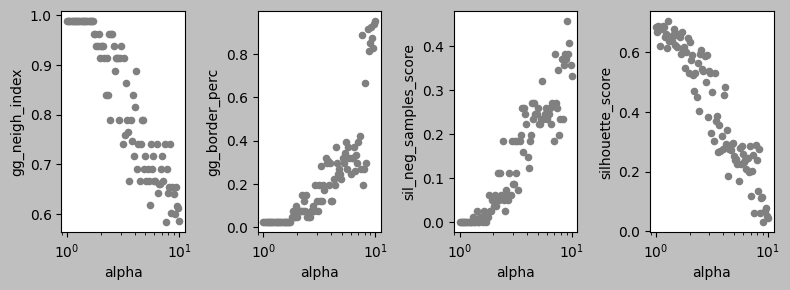

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(8, 3))

df.plot.scatter(x="alpha", y="gg_neigh_index", ax=ax[0])
ax[0].set_xscale("log")

df.plot.scatter(x="alpha", y="gg_border_perc", ax=ax[1])
ax[1].set_xscale("log")

df.plot.scatter(x="alpha", y="sil_neg_samples_score", ax=ax[2])
ax[2].set_xscale("log")

df.plot.scatter(x="alpha", y="silhouette_score", ax=ax[3])
ax[3].set_xscale("log")

plt.tight_layout()
plt.show()
plt.close()

## Visualize

In [35]:
blobs = get_australian_credit()
hidden_layer_sizes = (256, 128, 64, 32, 16, 8, 2)

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_overfit = exec_nn(
        *blobs,
        hidden_layer_sizes=hidden_layer_sizes, reg_alpha=1e0,
    )

In [37]:
print(classification_report(y_true=res_overfit.y_test, y_pred=res_overfit.pred_test))

              precision    recall  f1-score   support

          -1       0.87      0.77      0.81       115
           1       0.75      0.86      0.80        92

    accuracy                           0.81       207
   macro avg       0.81      0.81      0.81       207
weighted avg       0.82      0.81      0.81       207



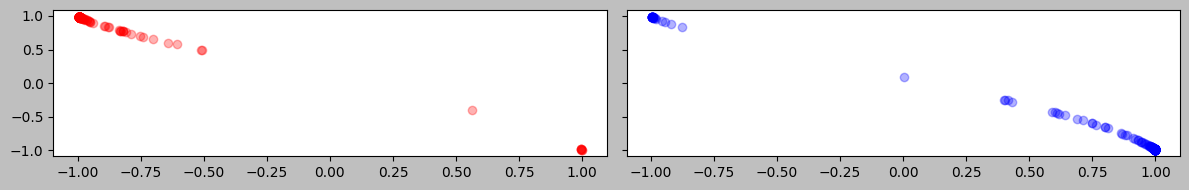

In [38]:
sel_c0 = np.where(res_overfit.y_train > 0)
sel_c1 = np.where(res_overfit.y_train < 0)

_, ax = plt.subplots(1, 2, figsize=(12, 2), sharex="all", sharey="all")

ax[0].scatter(res_overfit.projection[sel_c0, 0], res_overfit.projection[sel_c0, 1], color="red", alpha=.3)
ax[1].scatter(res_overfit.projection[sel_c1, 0], res_overfit.projection[sel_c1, 1], color="blue", alpha=.3)

plt.tight_layout()
plt.show()
plt.close()

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res_rightfit = exec_nn(
        *blobs,
        hidden_layer_sizes=hidden_layer_sizes, reg_alpha=1e1,
    )

In [42]:
print(classification_report(y_true=res_rightfit.y_test, y_pred=res_rightfit.pred_test))

              precision    recall  f1-score   support

          -1       0.87      0.84      0.86       115
           1       0.81      0.85      0.83        92

    accuracy                           0.85       207
   macro avg       0.84      0.85      0.84       207
weighted avg       0.85      0.85      0.85       207



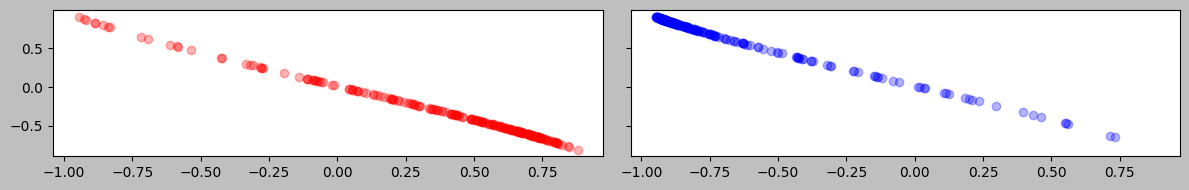

In [43]:
sel_c0 = np.where(res_rightfit.y_train > 0)
sel_c1 = np.where(res_rightfit.y_train < 0)

_, ax = plt.subplots(1, 2, figsize=(12, 2), sharex="all", sharey="all")

ax[0].scatter(res_rightfit.projection[sel_c0, 0], res_rightfit.projection[sel_c0, 1], color="red", alpha=.3)
ax[1].scatter(res_rightfit.projection[sel_c1, 0], res_rightfit.projection[sel_c1, 1], color="blue", alpha=.3)

plt.tight_layout()
plt.show()
plt.close()

---